In [134]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import remove_small_objects
import imageio

In [135]:
line_conf = np.load('line_detec_confidence_map.npy')
morph_conf = np.load('morph_conf.npy')
nn_conf = np.load('yhat_21.npy')

In [136]:
def combine_confidence_maps(*maps):
    combined_map = np.mean(np.array(maps), axis=0)
    return combined_map


In [137]:
def apply_optic_disk_mask(combined_map, morphological_map, mask):
    return np.where(mask, morphological_map, combined_map)


In [138]:
def get_mask(img, threshold):
    green_channel = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize = (8, 8))
    equalised_green_channel = clahe.apply(green_channel)
    mask = np.where(equalised_green_channel > 70, 1, 0).astype(np.uint8)
    dilated_mask = cv2.dilate(mask, np.ones((5, 5), np.uint8))
    return equalised_green_channel

In [139]:
def hybrid_vessel_segmentation_(*maps, threshold = 80, apply_mask=False, morphological_map=None, mask=None, img_):
    if apply_mask and morphological_map is not None and mask is not None:
        combined_map = apply_optic_disk_mask(img, morphological_map, mask)
        combined_map = combine_confidence_maps(combined_map, line_conf, nn_conf)
        _, thresh_img = cv2.threshold(combined_map, threshold, 255, cv2.THRESH_BINARY)
    else:
        combined_map = combine_confidence_maps(*maps)
        _, thresh_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    cleaned_image = remove_small_objects(thresh_img.astype(bool), min_size=100).astype(np.uint8) * 255
    return cleaned_image


In [140]:
line_conf = cv2.convertScaleAbs(line_conf, alpha=(255.0))
morph_conf = cv2.convertScaleAbs(morph_conf, alpha=(255.0))
nn_conf = cv2.convertScaleAbs(nn_conf, alpha=(255.0))

In [141]:
img = combine_confidence_maps(line_conf, morph_conf, nn_conf)

In [142]:
img_rgb = cv2.cvtColor(cv2.imread('../DRIVE/training/images/21_training.tif'), cv2.COLOR_BGR2RGB)

In [143]:
final_img_mhybrid = hybrid_vessel_segmentation_(img, threshold=77, apply_mask = True, morphological_map = morph_conf, mask = get_mask(img_rgb, 100), img_ = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY))

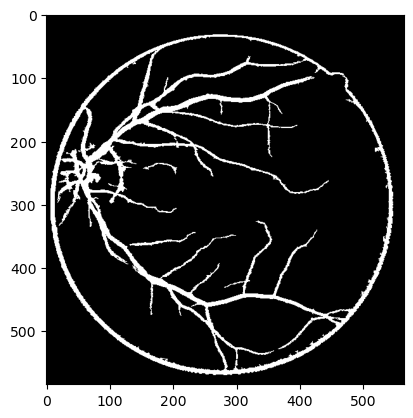

In [144]:
plt.imshow(final_img_mhybrid, cmap='gray')

In [145]:
final_img_hybrid = hybrid_vessel_segmentation_(img, threshold=77, img_ = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY))

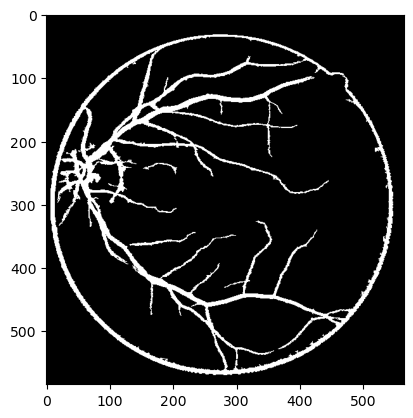

In [146]:
plt.imshow(final_img_hybrid, cmap='gray')